# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

data_dir = "./dataset/"

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "./dataset/"
image_dir = "./images/"


## Loading the data

In [2]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

In [5]:
# find numerical and categorical columns
nume_cols = list(df_train0.select_dtypes(include="number").columns)
cate_cols = list(df_train0.select_dtypes(exclude="number").columns)
nume_cols.remove('CUST_ZIP')
cate_cols.append('CUST_ZIP')
cate_cols.remove('FRAUD_NONFRAUD')

## Data Imputation and Wrangling

In [7]:
impute_vals={}

for col in df_train0.columns:
    if col in nume_cols:
        impute_vals[col] = df_train0[col].median()
    elif col in cate_cols:
        impute_vals[col] = df_train0[col].mode()[0]
        
impute_vals

{'TRAN_AMT': 162.07,
 'ACCT_PRE_TRAN_AVAIL_BAL': 2396.1549999999997,
 'CUST_AGE': 59.0,
 'OPEN_ACCT_CT': 5.0,
 'WF_dvc_age': 366.5,
 'PWD_UPDT_TS': '5/18/2020 4:7:20',
 'CARR_NAME': 'cox communications inc.',
 'RGN_NAME': 'southwest',
 'STATE_PRVNC_TXT': 'california',
 'ALERT_TRGR_CD': 'MOBL',
 'DVC_TYPE_TXT': 'MOBILE',
 'AUTHC_PRIM_TYPE_CD': 'UN_PWD',
 'AUTHC_SCNDRY_STAT_TXT': 'ALLOW',
 'CUST_ZIP': 77459,
 'CUST_STATE': 'CA',
 'PH_NUM_UPDT_TS': '7/8/2019 6:45:37',
 'CUST_SINCE_DT': Timestamp('1997-08-01 00:00:00'),
 'TRAN_TS': datetime.datetime(2021, 10, 1, 0, 0),
 'TRAN_DT': '2/28/2021',
 'ACTN_CD': 'SCHPMT',
 'ACTN_INTNL_TXT': 'P2P_COMMIT',
 'TRAN_TYPE_CD': 'P2P',
 'ACTVY_DT': '2/28/2021'}

In [8]:
def impute_data(df, impute_dict=impute_vals):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [9]:
def wrangle_column_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

## Modeling 1: Use only Numerical features

In [10]:
df1 = df_train0.copy()
df1["FRAUD_NONFRAUD"] =  df1["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1 = impute_data(df1)
df1 = wrangle_column_data(df1)

In [11]:
# test data
df1_te = df_test0.copy()
df1_te["FRAUD_NONFRAUD"] = df1_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1_te = impute_data(df1_te)
df1_te = wrangle_column_data(df1_te)

In [13]:
X_train1, y_train1 = df1[nume_cols], df1["FRAUD_NONFRAUD"]
X_test1,  y_test1  = df1_te[nume_cols], df1_te["FRAUD_NONFRAUD"]

In [17]:
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((11200, 5), (11200,), (2800, 5), (2800,))

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [19]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        
        self.model.fit(self.X_train, self.y_train)
    
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = "images/displot_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):

        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":self.model.feature_importances_})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = "images/feat_imp_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')
        
    def plot_roc_curve(self):
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)
        label_name = self.savename +"\nAUC = "+str(roc_auc)
        
        plot_roc_curve(self.model, self.X_test, self.y_test,
                       lw=3., color='C2', label=label_name)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xticks(fontsize=16);
        plt.yticks(fontsize=16);
        plt.legend(loc="center", fontsize=14);
        plt.axvline(x=0, color='k', ls='--', lw=1)
        plt.axhline(y=0, color='k', ls='--', lw=1)
        plt.axhline(y=1, color='k', ls='--', lw=1)
        
        figname = "images/roc_curve_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

Accuracy = 93.5% F1 Score= 88.52% 
Precision=93.23% Recall= 84.27%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.93      0.84      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.94      0.93      2800



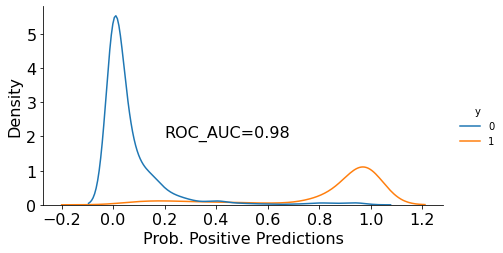

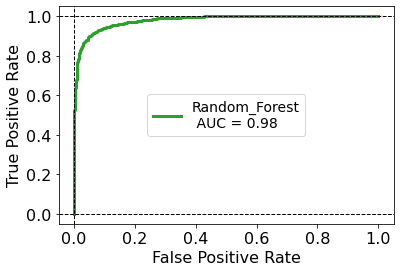

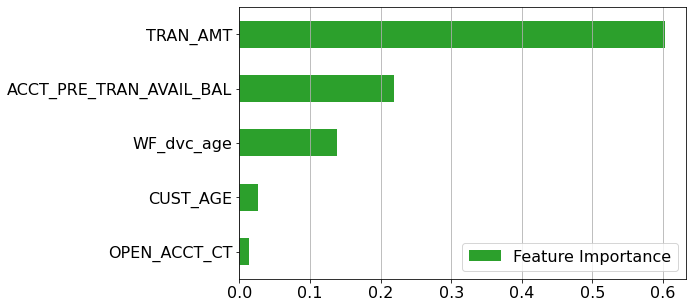

In [20]:
model_rf = RandomForestClassifier(max_depth=10,
                                  random_state=8848)

mod = Model_training(model_rf, 
                     X_train1, y_train1,
                     X_test1, y_test1,
                     "Random_Forest")
mod_tr, _= mod.print_metrics()
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

For a base model: F1 score  ~ 88% is a great result.

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   22.5s finished


Accuracy = 93.57% F1 Score= 88.74% 
Precision=92.68% Recall= 85.11%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.93      2800



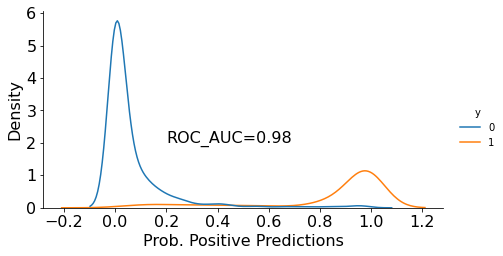

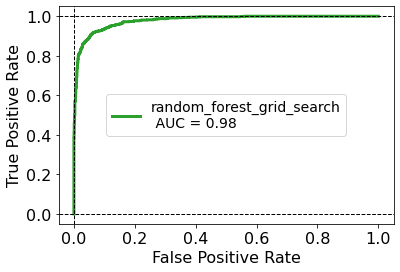

In [21]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[8, 10, 11, 12, 13]},
                           scoring ='f1',
                           verbose=1)

mod2 = Model_training(model_rf_gs,
                      X_train1, y_train1, X_test1, y_test1,
                      "random_forest_grid_search")
mod_tr, _= mod2.print_metrics()
mod2.displot()
mod2.plot_roc_curve()

In [22]:
mod_tr.best_params_

{'max_depth': 13}

Accuracy = 70.54% F1 Score= 22.1% 
Precision=51.77% Recall= 14.05%
              precision    recall  f1-score   support

           0       0.72      0.94      0.82      1967
           1       0.52      0.14      0.22       833

    accuracy                           0.71      2800
   macro avg       0.62      0.54      0.52      2800
weighted avg       0.66      0.71      0.64      2800



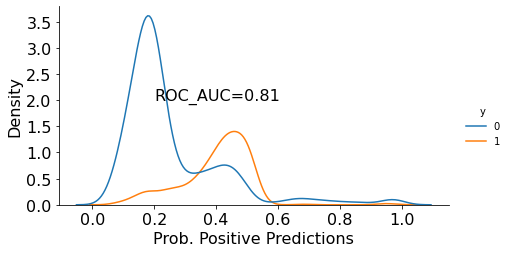

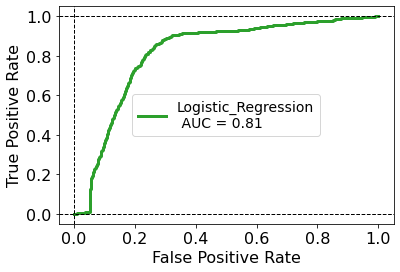

In [24]:
model_lr = LogisticRegression(max_iter=5000)
mod3 = Model_training(model_lr, X_train1, y_train1, X_test1, y_test1, "Logistic_Regression")
mod_tr, _= mod3.print_metrics()
mod3.displot()
mod3.plot_roc_curve()

Accuracy = 93.04% F1 Score= 87.93% 
Precision=90.79% Recall= 85.23%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.91      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



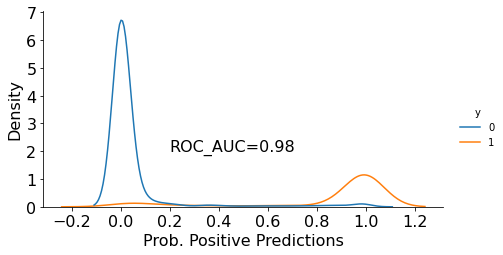

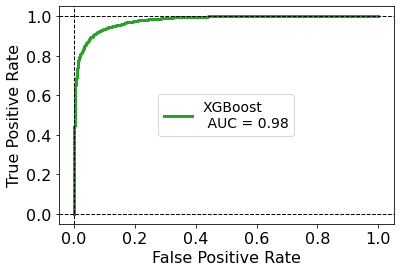

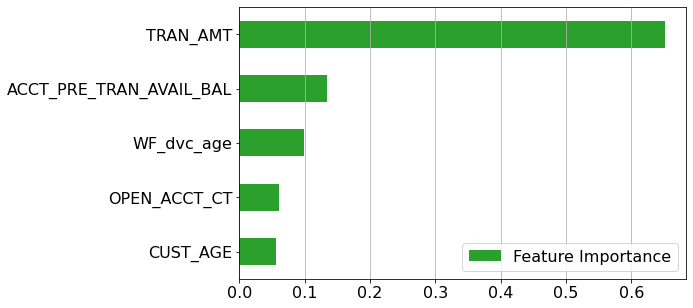

In [27]:
xgb = XGBClassifier(verbosity=1,
                    use_label_encoder=False, 
                    max_depth=10, 
                    eval_metric = "logloss")

mod4 = Model_training(xgb, X_train1, y_train1, X_test1, y_test1, "XGBoost")
mod_tr, _= mod4.print_metrics()
mod4.displot()
mod4.plot_roc_curve()
mod4.feature_importance()

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



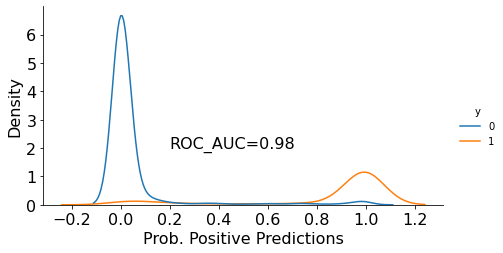

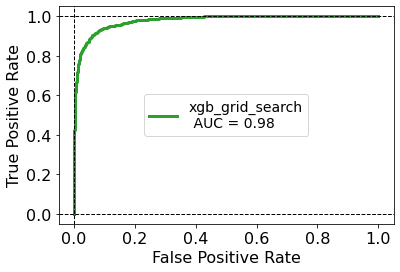

In [28]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0 )

mod5 = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1, "XGBoost_grid_search")
mod_tr, _= mod5.print_metrics()
mod5.displot()
mod5.plot_roc_curve()

In [29]:
mod_tr.best_params_

{'eval_metric': 'logloss', 'max_depth': 11, 'reg_alpha': 0.1}

## Deep learning models

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K

In [31]:
# this piece of code copied from 
#https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=custom_f1)
    return model

In [33]:
model_dnn = make_model_dense(X_train1, y_train1)
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_dnn = model_dnn.fit(X_train1, y_train1,
                            validation_data=(X_test1, y_test1),
                            epochs=20,
                            batch_size=32,
                            verbose=0)

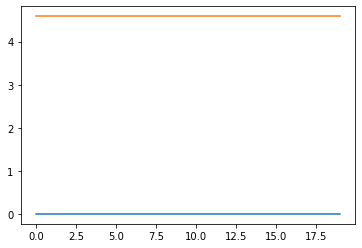

In [35]:
plt.plot(history_dnn.history['val_custom_f1'])
plt.plot(history_dnn.history['val_loss'])

## Modeling 2: Numerical + Categorical features

In [36]:
import category_encoders as ce

In [37]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = impute_data(df2)
df2 = wrangle_column_data(df2)

In [40]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE"]

In [46]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df2[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join
y_train2 = df2["FRAUD_NONFRAUD"]

In [47]:
# test data
df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] = df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = impute_data(df2_te)
df2_te = wrangle_column_data(df2_te)

In [48]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join
y_test2 = df2_te["FRAUD_NONFRAUD"]

In [49]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 12), (11200,), (2800, 12), (2800,))

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



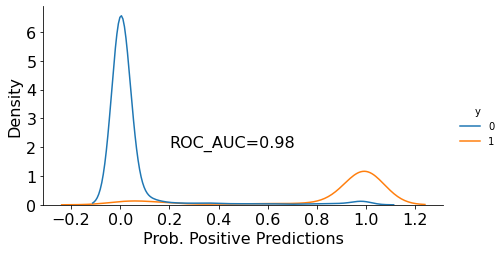

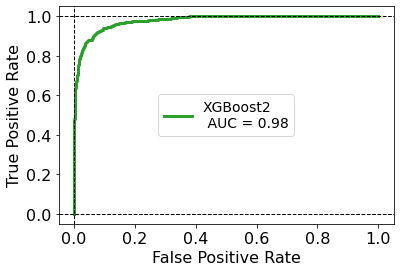

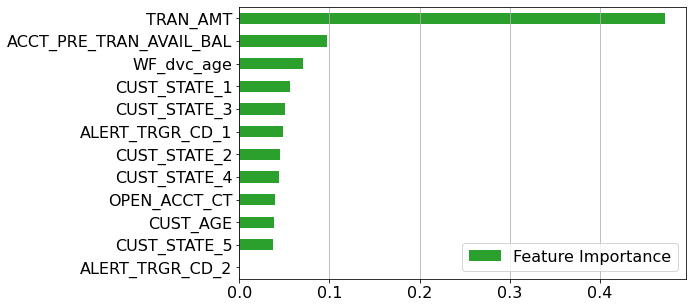

In [51]:
xgb = XGBClassifier(verbosity=1,
                    max_depth=10,
                    eval_metric = "logloss")

mod6 = Model_training(xgb, X_train2, y_train2, X_test2, y_test2, "XGBoost2")
mod_trained, _ = mod5.print_metrics()
mod6.displot()
mod6.plot_roc_curve()
mod6.feature_importance()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   30.5s finished


Accuracy = 93.79% F1 Score= 89.12% 
Precision=92.96% Recall= 85.59%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.94      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



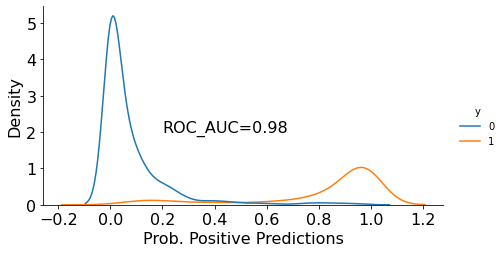

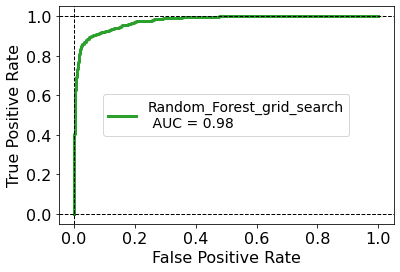

In [54]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[10, 11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod7 = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "Random_Forest_grid_search")

mod_tr, _= mod7.print_metrics()
mod7.displot()
mod7.plot_roc_curve()

In [53]:
mod_tr.best_params_

{'max_depth': 13}

remove ALERT_TRGR_CD from features

In [55]:
X_train2.head(1)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,ALERT_TRGR_CD_1,ALERT_TRGR_CD_2,CUST_STATE_1,CUST_STATE_2,CUST_STATE_3,CUST_STATE_4,CUST_STATE_5
2413,487.93,3714.91,43,5,1037,1,0,1,0,0,0,0


In [58]:
cols = [c for c in list(X_train2.columns) if c not in ["ALERT_TRGR_CD_1","ALERT_TRGR_CD_2"]]
cols

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age',
 'CUST_STATE_1',
 'CUST_STATE_2',
 'CUST_STATE_3',
 'CUST_STATE_4',
 'CUST_STATE_5']

In [59]:
X_train3 = X_train2[cols]
X_test3  = X_test2[cols]
y_train3 = y_train2
y_test3  = y_test2

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   18.8s finished


Accuracy = 93.61% F1 Score= 88.75% 
Precision=93.14% Recall= 84.75%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



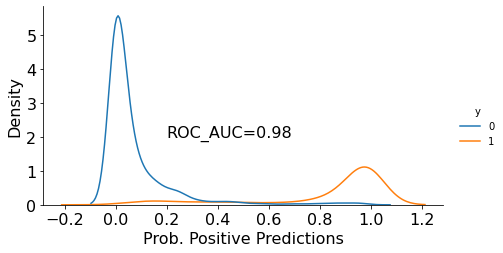

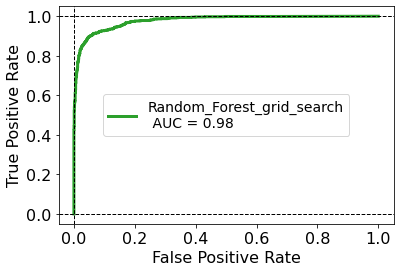

In [60]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod8 = Model_training(model_rf_gs,
                      X_train3, y_train3, X_test3, y_test3,
                      "Random_Forest_grid_search")

mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()

In [96]:
from sklearn.svm import SVC

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



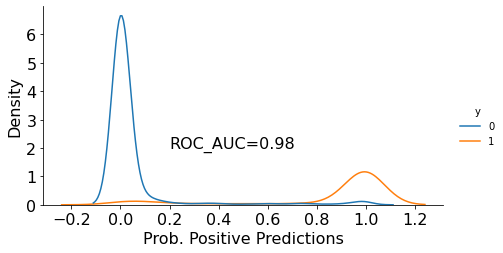

In [97]:
svm = SVC(gamma='auto')
mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [98]:
def train_svm_gs():
    svm_gs = GridSearchCV(SVC(),
                          param_grid={'C':[0.1, 0.5, 1.0],
                                      'kernel':['poly', 'rbf'],
                                      'gamma': ['scale', 'auto']},
                          scoring = 'f1',
                          verbose = 1 )
    
    mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
    mod_tr, _= mod.print_metrics()
    mod.displot()
    
#this takes a little long time so think before running
#train_svm_gs()